# Importing Libraries ( will use Tensorflow )

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os

from PIL import Image

import string

d:\DownLoads_2\MiniConda\MiniCondaa\envs\selenium\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\DownLoads_2\MiniConda\MiniCondaa\envs\selenium\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\DownLoads_2\MiniConda\MiniCondaa\envs\selenium\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_han

# Extracting Data (train / validation)

In [2]:
df_train = pd.read_csv('../Data/sign_mnist_train.csv')

In [3]:
df_vali = pd.read_csv('../Data/sign_mnist_test.csv')

In [41]:
len(df_train), len(df_vali)

(27455, 7172)

# Splitting

In [4]:
x_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values

x_vali = df_vali.drop('label', axis=1).values
y_vali = df_vali['label'].values

# Sample

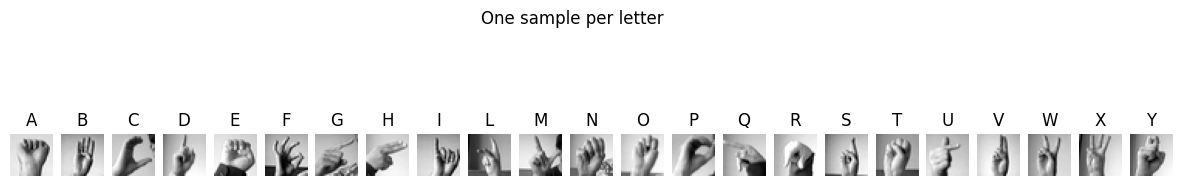

In [49]:
letters = list(string.ascii_uppercase)
letters.remove('J')
letters.remove('Z')

plt.figure(figsize=(15,3))

display_indices = {}
for letter_idx in range(len(letters)):
    idx_train = np.where(y_train == letter_idx)[0]
    idx_test = np.where(y_vali == letter_idx)[0]
    
    if len(idx_train) > 0:
        display_indices[letter_idx] = ('train', idx_train[0])
    elif len(idx_test) > 0:
        display_indices[letter_idx] = ('test', idx_test[0])

for i, letter_idx in enumerate(sorted(display_indices.keys())):
    source, idx = display_indices[letter_idx]
    if source == 'train':
        img = x_train[idx]
    else:
        img = x_vali[idx]
    plt.subplot(1, len(display_indices), i+1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title(letters[letter_idx])
    plt.axis('off')

plt.suptitle("One sample per letter")
plt.show()

In [44]:
len(x_train), len(y_train), len(x_vali), len(y_vali)

(27455, 27455, 7172, 7172)

# Reshape + Normalization 

In [45]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_vali = x_vali.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [46]:
x_train.min(), x_train.max(), x_vali.min(), x_vali.max()

(np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(1.0))

In [47]:
x_train.min(), x_train.max(), x_vali.min(), x_vali.max()

(np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(1.0))

# Distribution

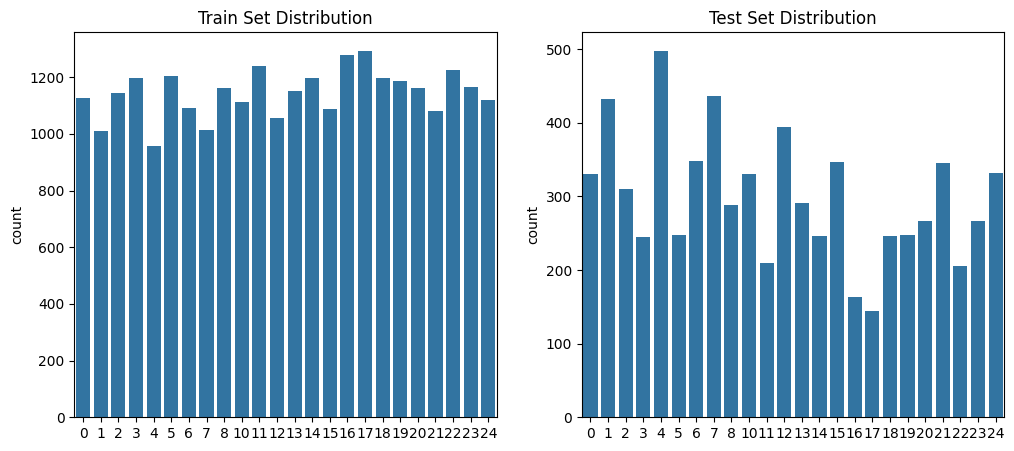

In [48]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Train Set Distribution")

plt.subplot(1,2,2)
sns.countplot(x=y_vali)
plt.title("Test Set Distribution")

plt.show()

# Data Augmentation

In [50]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

In [51]:
datagen.fit(x_train)

# Model Creation

In [52]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(25, activation='softmax')
])

In [53]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
cbs = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

# Model Training

In [55]:
history = model.fit(                  
          datagen.flow(x_train, y_train,batch_size=32, shuffle=True),
          epochs=15,
          validation_data=(x_vali, y_vali),
          callbacks=cbs
          )

Epoch 1/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.2745 - loss: 2.4095 - val_accuracy: 0.8608 - val_loss: 0.5916
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.7216 - loss: 0.8477 - val_accuracy: 0.9155 - val_loss: 0.3078
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8118 - loss: 0.5538 - val_accuracy: 0.9506 - val_loss: 0.1891
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8579 - loss: 0.4284 - val_accuracy: 0.9647 - val_loss: 0.1340
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.8867 - loss: 0.3496 - val_accuracy: 0.9714 - val_loss: 0.1108
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9034 - loss: 0.2880 - val_accuracy: 0.9831 - val_loss: 0.0720
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.9136 - loss: 0.2538 - val_accuracy: 0.9803 - val_loss: 0.0704
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9248 - loss: 0.2288 - 

# Accuracy

In [56]:
vali_loss, vali_acc = model.evaluate(x_vali, y_vali)
print("vali accuracy:", vali_acc)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9978 - loss: 0.0220
vali accuracy: 0.9969325065612793


# Samples


In [ ]:
predictions = model.predict(x_vali)

predictions = np.argmax(predictions, axis=1)

for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


array([ 6,  5, 11,  0,  3])

In [59]:
correct = np.nonzero(predictions == y_vali)[0]

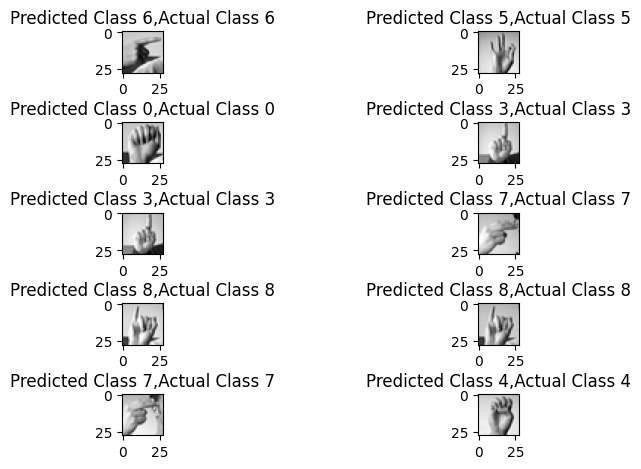

In [67]:
i = 0
for c in correct[:10]:
    plt.subplot(5,2,i+1)
    plt.imshow(x_vali[c].reshape(28,28), cmap="gray")
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_vali[c]))
    plt.tight_layout()
    i += 1
plt.subplots_adjust(hspace=1.2, wspace=0.4) 
plt.show()

In [63]:
path = "../Model/sign_mnist_model.keras"
if os.path.exists(path):
    os.remove(path)
    print("File deleted successfully")
model.save(path)
print("Saved Model")

File deleted successfully
Saved Model


# Extracting Image (IGNORE)

In [5]:
x_test = df_vali.iloc[:,1:].values.reshape(-1,28,28)
y_test = df_vali.iloc[:,0].values

In [6]:
alphabet = [chr(i) for i in range(ord('A'), ord('Z')+1)]

- Save Images

In [7]:
save_path = "../Pictures"

for i in range(100):
    img_array = x_test[i] * 255  # scale back
    img = Image.fromarray(img_array.astype(np.uint8), mode="L")
    img = img.resize((224,224), Image.NEAREST)
    letter = alphabet[y_test[i]] 
    img.save(os.path.join(save_path, f"image_{i}_label_{letter}.png"))